# Lab Exercise 7: Principal Component Analysis (PCA) of Surface Winds

In this exercise, we will explore how Principal Component Analysis (PCA), or Empirical Orthogonal Function (EOF) analysis, can be used to identify dominant modes of variability in surface winds.

Using monthly 10 m winds from ERA5, we will extract spatial modes and time series (Principal Components) that represent large-scale patterns such as the Amihan–Habagat monsoon reversal and the ENSO influence on wind variability.

By the end of this exercise, you should be able to:
1. Load gridded wind data efficiently with xarray and dask.
2. Compute EOFs using the xeofs library.
3. Interpret the first mode as the seasonal monsoon cycle.
4. Relate higher modes (e.g., Mode 4) to ENSO phases using the Niño 3.4 index.

### Step 0 – Setup and Data Preparation

For this exercise we’ll analyze surface winds from the ERA5 Reanalysis using `xarray`, `dask`, and `xeofs`.

Make sure your environment is ready before running the next steps. Install the needed packages either through anaconda prompt, or by running the script provided in a new cell.

```bash
!conda install -c conda-forge -n meteo203 xeofs dask -y
```

Download the monthly surface wind data from [this link](https://drive.google.com/file/d/1jLCPelp5nwUqFLbcD25Bl7SVXKv2Tk6F/view?usp=drive_link). In the same directory as this notebook, create a new folder `era5-surface-winds`. Extract the contents of the file you downloaded in this folder.

Check if the setup is working using the following cell.

In [3]:
# Step 0 – Verify setup and environment
import xeofs as xe
import xarray as xr
from pathlib import Path
import numpy as np

data_path = Path("..\..\data\era5-surface-winds")
files = sorted(data_path.glob("era5-surface-wind-monthly-*.nc"))

print(f"Found {len(files)} NetCDF files in {data_path}")
print("First few files:", [f.name for f in files[:5]])

Found 55 NetCDF files in ..\..\data\era5-surface-winds
First few files: ['era5-surface-wind-monthly-1970.nc', 'era5-surface-wind-monthly-1971.nc', 'era5-surface-wind-monthly-1972.nc', 'era5-surface-wind-monthly-1973.nc', 'era5-surface-wind-monthly-1974.nc']


If the script above displays the list of the netcdf files, we can proceed with Step 1. 

---
### Step 1 – Load the ERA5 surface wind dataset

ERA5 monthly 10 m wind components (u10, v10) are stored in yearly NetCDF files.

We’ll use `xarray` and `dask` to load them efficiently.

**Note:** When you run the next cell, you might see messages like
```bash
sh: 1: getfattr: not found
```
These are harmless warnings related to file attributes.
You can safely ignore them — they do not affect the dataset or results.

In [4]:
from pathlib import Path

data_path = Path("..\..\data\era5-surface-winds")
ds = xr.open_mfdataset(
    str(data_path / "era5-surface-wind-monthly-*.nc"),
    combine="by_coords",
    parallel=True
)

#### Inspect the dataset Let’s check what variables and dimensions are included.

In [5]:
ds

<xarray.Dataset> Size: 301MB
Dimensions:    (time: 648, latitude: 241, longitude: 241)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 2kB 60.0 59.75 59.5 59.25 ... 0.5 0.25 0.0
  * longitude  (longitude) float64 2kB 100.0 100.2 100.5 ... 159.5 159.8 160.0
  * time       (time) datetime64[ns] 5kB 1970-01-31 1970-02-28 ... 2024-12-31
    year       (time) int64 5kB dask.array<chunksize=(12,), meta=np.ndarray>
    month      (time) int64 5kB dask.array<chunksize=(12,), meta=np.ndarray>
Data variables:
    u10        (time, latitude, longitude) float32 151MB dask.array<chunksize=(12, 241, 241), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 151MB dask.array<chunksize=(12, 241, 241), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-29T15:08 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
# Display dataset summary
ds.info()

# Optional: view coordinate ranges
print("Time coverage:", str(ds.time[0].values)[:10], "to", str(ds.time[-1].values)[:10])
print("Latitude range:", float(ds.latitude.min()), "to", float(ds.latitude.max()))
print("Longitude range:", float(ds.longitude.min()), "to", float(ds.longitude.max()))

xarray.Dataset {
dimensions:
	time = 648 ;
	latitude = 241 ;
	longitude = 241 ;

variables:
	float32 u10(time, latitude, longitude) ;
		u10:GRIB_paramId = 165 ;
		u10:GRIB_dataType = an ;
		u10:GRIB_numberOfPoints = 101441 ;
		u10:GRIB_typeOfLevel = surface ;
		u10:GRIB_stepUnits = 1 ;
		u10:GRIB_stepType = instant ;
		u10:GRIB_gridType = regular_ll ;
		u10:GRIB_uvRelativeToGrid = 0 ;
		u10:GRIB_NV = 0 ;
		u10:GRIB_Nx = 361 ;
		u10:GRIB_Ny = 281 ;
		u10:GRIB_cfName = unknown ;
		u10:GRIB_cfVarName = u10 ;
		u10:GRIB_gridDefinitionDescription = Latitude/Longitude Grid ;
		u10:GRIB_iDirectionIncrementInDegrees = 0.25 ;
		u10:GRIB_iScansNegatively = 0 ;
		u10:GRIB_jDirectionIncrementInDegrees = 0.25 ;
		u10:GRIB_jPointsAreConsecutive = 0 ;
		u10:GRIB_jScansPositively = 0 ;
		u10:GRIB_latitudeOfFirstGridPointInDegrees = 60.0 ;
		u10:GRIB_latitudeOfLastGridPointInDegrees = -10.0 ;
		u10:GRIB_longitudeOfFirstGridPointInDegrees = 90.0 ;
		u10:GRIB_longitudeOfLastGridPointInDegrees = 180.0 ;
	

#### Questions
1. What are the main dimensions of this dataset?<br>
**The dimensions are time (660) x latitude (241) x longitude (241)**
2. Which variables are included?<br>
**The variables are the meridional and zonal wind at 10 meters.**
3. How many years of monthly data do we have?<br>
**We have data spanning 54 years. from 1970 - 2024.**
4. What is the spatial extent (lat, lon) of this dataset?<br>
**The latitude spans from 0.0 - 60.0 degrees, while the longitude spans from 100.0 - 160.0 degrees.**

---
### Step 2 – Plot the long-term mean of the zonal wind (u10)
The zonal wind (`u10`) represents the **east–west component** of the near-surface wind:

- Positive values → westerly winds (blowing from west to east)
- Negative values → easterly winds (blowing from east to west)

In this step, we’ll compute the long-term mean of `u10` (averaged from 1970–2024)
and visualize the resulting climatological pattern.

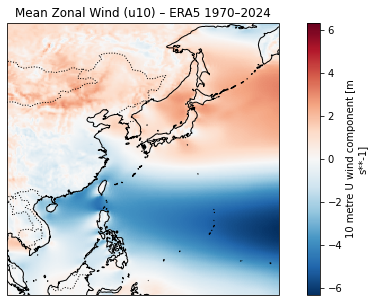

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

u_mean = ds["u10"].mean(dim="time")

fig, ax = plt.subplots(figsize=(10,5), subplot_kw={"projection": ccrs.PlateCarree()})
pcm = u_mean.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=True)
ax.coastlines(resolution="50m")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("Mean Zonal Wind (u10) – ERA5 1970–2024")
plt.show()

Interpreting the map. The sign of `u10` tells us the predominant wind direction.

| `u10` value | Direction | Interpretation |
|--------------|------------|----------------|
| **Negative (blue)** | Easterlies | Winds blowing **from east to west** |
| **Positive (red)** | Westerlies | Winds blowing **from west to east** |



Over the tropical Pacific, the long-term mean shows strong negative values,
meaning persistent easterlies — these are the trade winds that drive equatorial upwelling and influence ENSO variability.

Meanwhile, positive values appear over the mid-latitudes (especially north of ~25°N),
corresponding to westerly flows associated with the subtropical jet stream.

#### Questions
1. What do you notice about the transition from easterlies (blue) to westerlies (red)?<br>
**The transition from easterlies to westerlies show a white color, indicating an anomaly close to zero, which means that the average wind direction here flips between one and the other. The transition is positioned around the mid-latitudes as well.**
2. How does this relate to the Hadley cell and the intertropical convergence zone (ITCZ)?<br>
**Since the Hadley cell sinks around the mid-latitudes, these transitions show us where the trade winds end, and the westerlies begin. Not only that, but the bulk of where the negative anomalies are found is where the ITCZ hovers, meaning that most wind there will be converging towards it in the form of easterlies.**

---
### Step 3 – Plot Seasonal Averages of Zonal Wind (JJA vs SON)

Before we apply PCA, let’s first explore the seasonal structure of the 10 m zonal wind (u10).
We’ll compute and compare the climatological means for two key monsoon seasons:
- JJA (June–August) → Habagat / Southwest Monsoon
- SON (September–November) → Transition toward Amihan / Northeast Monsoon

This helps us visualize how the prevailing wind direction changes through the year.

C:\Users\elija\AppData\Local\Temp\ipykernel_24012\1684527124.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


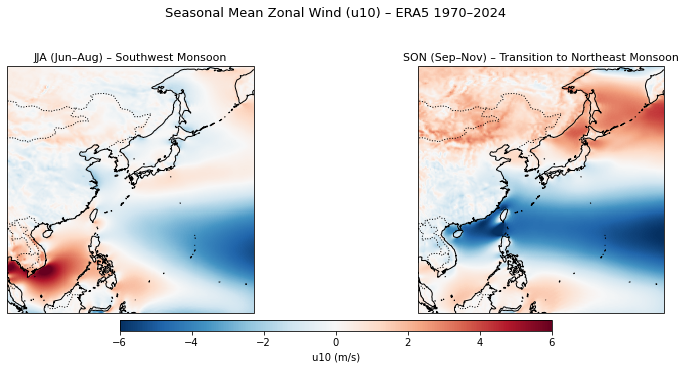

In [8]:
# Compute monthly climatology (mean over all years)
u_monthly_clim = ds["u10"].groupby("time.month").mean("time")

# Select representative monsoon seasons
u_JJA = u_monthly_clim.sel(month=[6,7,8]).mean("month")
u_SON = u_monthly_clim.sel(month=[9,10,11]).mean("month")

# --- Plot ---
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(1, 2, figsize=(12,5), subplot_kw={'projection': ccrs.PlateCarree()})

for ax, data, title in zip(
    axes,
    [u_JJA, u_SON],
    ["JJA (Jun–Aug) – Southwest Monsoon", "SON (Sep–Nov) – Transition to Northeast Monsoon"]
):
    pcm = data.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r",
        vmin=-6, vmax=6, add_colorbar=False
    )
    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(title, fontsize=11)

# Shared colorbar below both subplots
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.03])  # [left, bottom, width, height]
fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal", label="u10 (m/s)")

plt.suptitle("Seasonal Mean Zonal Wind (u10) – ERA5 1970–2024", fontsize=13, y=0.98)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

#### Questions

1. Which regions show negative u10 values (easterlies) and which show positive u10 values (westerlies)?<br>
**The easterlies are mostly concentrated in the west pacific, extending until southern China during SON, while the westelies are common in the lower latitudes during the JJA season, and in the mid-latitudes during SON.**
2. How does the latitude affect the direction and strength of the zonal wind?<br>
**In some latitudes, the presence of easterlies/westerlies is significant. Easterlies are strongest between the equator and mid latitudes, while westerlies are stronger to the north/south of that region.**
3. In what regions do you notice the strongest winds during JJA and SON?<br>
**The strongest winds during JJA are seen southeast asian countries in the form of westerlies, while the strongest winds during SON can be seen in the west pacific, above the Philippines.**

---
### Step 4 – Extracting Dominant Wind Patterns using EOF Analysis

Empirical Orthogonal Function (EOF) analysis — also known as Principal Component Analysis (PCA) — helps us identify the dominant spatial patterns of variability in a dataset and their time evolution.

In this step, we’ll apply EOF analysis to the monthly 10 m zonal wind (u10) to see how large-scale wind patterns (like the monsoon reversal) emerge as principal modes

In [9]:
# Select u10 for EOF analysis
u = ds["u10"]

# --- Initialize EOF model ---
# 'use_coslat=True' weights grid cells by latitude area (important for global data)
model = xe.single.EOF(n_modes=5, use_coslat=True)

# --- Fit the model ---
model.fit(u, dim="time")

# --- Extract results ---
components = model.components()  # spatial patterns (EOFs)
scores = model.scores()          # time series (PCs)

# Show available modes
components

<xarray.DataArray 'components' (mode: 5, latitude: 241, longitude: 241)> Size: 2MB
array([[[ 2.70603653e-04,  6.28371695e-04,  4.31163521e-04, ...,
          5.53580935e-04,  5.84446181e-04,  5.87660295e-04],
        [ 6.17412973e-04,  4.00891320e-04,  1.82588032e-04, ...,
          8.47870261e-04,  8.63330932e-04,  8.77393558e-04],
        [ 5.71755337e-04,  3.07741070e-04,  3.00800184e-07, ...,
          1.12564226e-03,  1.13557681e-03,  1.15148702e-03],
        ...,
        [-5.12851535e-04, -4.91599081e-04, -5.27222454e-04, ...,
          3.62074386e-03,  3.33490028e-03,  2.90767828e-03],
        [-4.82263927e-04, -4.53257757e-04, -4.87101107e-04, ...,
          3.96924757e-03,  3.97028323e-03,  3.99867132e-03],
        [-5.07007874e-04, -4.89905856e-04, -5.11944694e-04, ...,
          4.04310447e-03,  4.15891590e-03,  4.27524134e-03]],

       [[-2.58936020e-04, -3.47761793e-04, -3.31739962e-04, ...,
         -5.25439345e-03, -5.25619825e-03, -5.25013177e-03],
        [-2.33670900e-04, -2.54307914e-04, -2.25719206e-04, ...,
         -5.36524806e-03, -5.36190510e-03, -5.35119492e-03],
        [-1.82380198e-04, -1.97400000e-04, -3.13332934e-04, ...,
         -5.47336946e-03, -5.46754891e-03, -5.45364863e-03],
...
        [ 6.69299107e-04,  6.50731233e-04,  6.91597739e-04, ...,
         -1.99243426e-03, -1.81985648e-03, -1.56634114e-03],
        [ 6.51065046e-04,  6.45688932e-04,  6.81157189e-04, ...,
         -2.36893323e-03, -2.36164444e-03, -2.37693086e-03],
        [ 6.79423062e-04,  6.86113624e-04,  7.10553962e-04, ...,
         -2.41167757e-03, -2.49942527e-03, -2.58755665e-03]],

       [[-7.97196716e-04, -2.22558967e-03, -2.17528370e-03, ...,
          1.54973046e-02,  1.55185822e-02,  1.55425640e-02],
        [-1.68025355e-03, -1.36822809e-03, -1.22451328e-03, ...,
          1.55378550e-02,  1.55487002e-02,  1.55631127e-02],
        [-1.63454083e-03, -1.18012431e-03, -9.00057672e-04, ...,
          1.55327356e-02,  1.55377452e-02,  1.55512072e-02],
        ...,
        [ 5.26639713e-04,  5.14127638e-04,  4.99144344e-04, ...,
          1.36854304e-03,  1.26001563e-03,  1.07089639e-03],
        [ 5.22529107e-04,  5.20371091e-04,  4.97870768e-04, ...,
          1.43911461e-03,  1.49303132e-03,  1.55918641e-03],
        [ 4.95657622e-04,  4.94719244e-04,  4.70172755e-04, ...,
          1.33561596e-03,  1.44145341e-03,  1.54726694e-03]]])
Coordinates:
  * latitude   (latitude) float64 2kB 0.0 0.25 0.5 0.75 ... 59.5 59.75 60.0
  * longitude  (longitude) float64 2kB 100.0 100.2 100.5 ... 159.5 159.8 160.0
    number     int64 8B 0
  * mode       (mode) int32 20B 1 2 3 4 5
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-12-06 18:34:50
    n_modes:        5
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

#### Understanding what happens here.

| Step           | What It Does                                                   | Meteorological Meaning                                     |
| -------------- | -------------------------------------------------------------- | ---------------------------------------------------------- |
| `fit()`        | Computes the covariance matrix of `u10` and finds eigenvectors | Identifies patterns that explain the largest variance      |
| `components()` | Spatial maps of each mode                                      | *Where* the variability happens (e.g. monsoon regions)     |
| `scores()`     | Time evolution of each mode                                    | *When* the variability happens (e.g. seasonal cycle, ENSO) |


The first mode (Mode 1) typically represents the largest-scale, most consistent pattern in your data — often the annual or monsoon cycle.

Now let's plot EOF1 and PC1. 

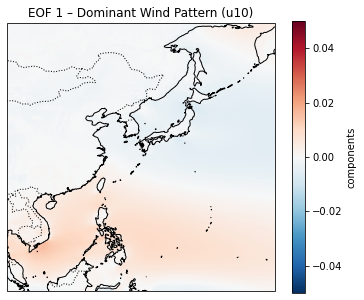

In [23]:
# --- Plot EOF1 ---
fig, ax = plt.subplots(figsize=(6,5), subplot_kw={'projection': ccrs.PlateCarree()})
components.sel(mode=1).plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-0.05, vmax=0.05
)
ax.coastlines(resolution="50m")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("EOF 1 – Dominant Wind Pattern (u10)")
plt.show()

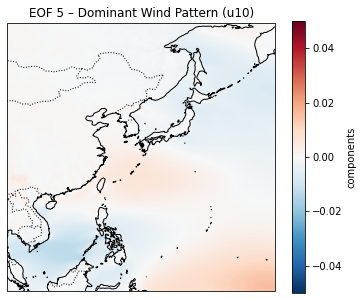

In [24]:
# --- Plot EOF5 ---
fig, ax = plt.subplots(figsize=(6,5), subplot_kw={'projection': ccrs.PlateCarree()})
components.sel(mode=5).plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-0.05, vmax=0.05
)
ax.coastlines(resolution="50m")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("EOF 5 – Dominant Wind Pattern (u10)")
plt.show()

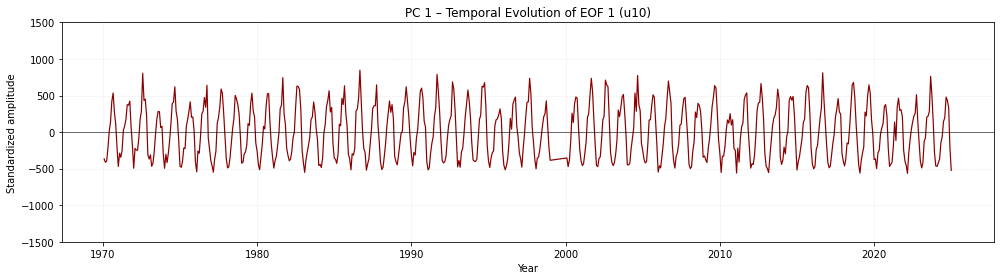

In [11]:
# --- Plot PC1 (time series) ---
fig, ax = plt.subplots(figsize=(14, 4))  # wider aspect ratio
scores.sel(mode=1).plot(ax=ax, color='darkred', lw=1.2)

ax.set_title("PC 1 – Temporal Evolution of EOF 1 (u10)", fontsize=12)
ax.set_ylabel("Standardized amplitude")
ax.set_xlabel("Year")
ax.set_ylim(-1500, 1500)
ax.grid(alpha=0.3, linestyle="--", linewidth=0.5)

# Optional: add a horizontal zero line for reference
ax.axhline(0, color="black", lw=0.8, alpha=0.7)

plt.tight_layout()
plt.show()

The PC 1 time series shows how the leading wind pattern changes through time.

The full PC 1 time series spans several decades, so it can be difficult to see the individual seasonal cycle. Let’s zoom in to one year to visualize how the monsoon reversal happens within a typical year.

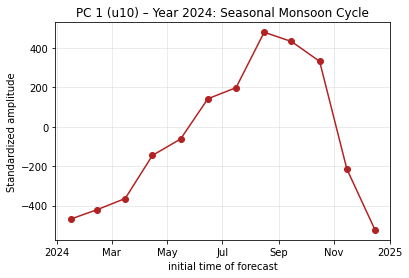

In [12]:
# Select one representative year (e.g., 2024)
pc1 = scores.sel(mode=1)

# Zoom in to one year
pc1_2024 = pc1.sel(time=slice("2024-01", "2024-12"))

# Center monthly timestamps by shifting 15 days earlier
pc1_2024_centered = pc1_2024.copy()
pc1_2024_centered["time"] = pc1_2024_centered["time"] - np.timedelta64(15, "D")

# Plot
pc1_2024_centered.plot(marker="o", color="firebrick")
plt.title("PC 1 (u10) – Year 2024: Seasonal Monsoon Cycle")
plt.ylabel("Standardized amplitude")
plt.grid(alpha=0.3)
plt.show()

The first Principal Component (PC1) represents the **dominant mode of variability** in the 10m zonal wind. By examining both the long-term record (1970-2024) and a single year (2024), we can explore how large-scale and seasonal wind patterns vary over time.

It summarizes how large-scale near-surface wind patterns evolve over time. Examine both the long-term record (1970 – 2024) and the single-year cycle (2024) before answering.

#### Questions
1. Long-Term Variability (1970 – 2024)
    - Describe the general shape and rhythm of the PC 1 time series across the full period.<br>
**PC 1 shows an oscillatory behavior, having a positive/negataive cycle that repeats yearly.**
    - What patterns or fluctuations stand out when you look across decades?<br>
**Most of the decades show peak negative standardized amplitude of -500, but some years show a very small peak in positive standardized amplitude, meaning weak westerlies.**
    - How would you characterize the years with unusually high or low amplitudes?<br>
**If not outliers, these years are probably affected by some large scale processes, indicating weak westerly or easterly winds.**
    - In what ways might long-term climate variations (e.g., ENSO, Pacific warming trends) influence this pattern? <br>
**If the phase of the ENSO inhibits convection in the western pacific, and if this is coupled with the season of the southwest monsoon, this could manifest in record low measures for the easterly strengths.**

2. Seasonal Evolution (Year 2024 Example)
    - How does the PC 1 amplitude progress through the months of 2024?<br>
**PC 1 amplitude generally starts low, with a maxima around Aug-Sep, before going back to negative values.**
    - Which parts of the year correspond to stronger or weaker zonal winds near the Philippines?<br>
**The strongest zonal winds will be around the minima or maxima of the graph in that year, which is Dec-Jan or Aug-Sep respectively. The weakest zonal winds will be when the amplitude is around 0, which will be around June or November.**
    - What do the rising and falling segments of the curve suggest about seasonal transitions?<br>
**The rising and falling segments indicate the shift from a prevailing wind pattern to another. This indicates the seasonal transition, which happens around November and May.**
    - Around which months does the shift between prevailing wind regimes occur, and how does this compare with the observed Amihan onset (mid-November 2024)?<br>
**The shift of the prevailing winds happen around November and June, which is in agreement with the observed Amihan onset, and also the Habagat onset as well.**


---
### Step 5 – Linking Wind Variability (EOF 4) to Sea Surface Temperature (SST) Anomalies

In this final step, we’ll explore whether one of the higher EOF modes of the surface wind field
corresponds to ENSO-related variability — similar to what you studied in Lesson 06.

To do this, we’ll load the same ERSST v6 dataset and compute the Niño 3.4 index, which represents the standardized SST anomaly in the central-eastern equatorial Pacific.

You’ll then compare this index with Mode 4 of the u10 EOF analysis to see if the winds respond to oceanic warming and cooling patterns.

In [13]:
from shapely.geometry import box

# --- Load SST data (edit the path if needed) ---
file_path = '..\..\data\ersst.v6.195001_202412.nc'   # ← Update this if your file is in another folder
ds_sst = xr.open_dataset(file_path)

# Inspect structure
ds_sst

<xarray.Dataset> Size: 115MB
Dimensions:  (time: 900, lev: 1, lat: 89, lon: 180)
Coordinates:
  * lat      (lat) float64 712B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lev      (lev) float64 8B 0.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 7kB 1950-01-15 1950-02-15 ... 2024-12-15
Data variables:
    sst      (time, lev, lat, lon) float32 58MB ...
    ssta     (time, lev, lat, lon) float32 58MB ...
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   gov.noaa.ncei:C01737
    id:                              ersst.v6.195001.nc
    naming_authority:                gov.noaa.ncei
    title:                           NOAA monthly ERSSTv6 (in situ only)
    summary:                         Monthly ERSSTv6 is developed based on v5...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    references:                      Huang, B., X. Yin, T. Boyer, C. Liu, M. ...
    climatology:                     Climatology is based on 1991-2020 SST of...
    acknowledgment:                  The NOAA Extended Reconstructed Sea Surf...
    NCO:                             netCDF Operators version 5.0.7 (Homepage...
    history:                         Fri May  2 14:08:56 2025: ncap2 -O -s ti...




#### Step 5a. Reproduce the Niño 3.4 anomaly and standardized index computation. 

Edit the file_path variable so that it points to your local copy of the SST file. You can copy your earlier code cells and adjust as needed. 

To recap, here are the key steps that are implemented in [Lesson 06](../../lessons/06_pca/06a_intro_to_pca.ipynb):
1. Extract the SST field
2. Compute the baseline climatology (1950–1979)
3. Select Niño 3.4 region and compute anomalies
4. Apply a 5-month rolling mean and standardize

Remember, we are calculating the ONI, NOT the PCA of the SSTs. After successfuly calculating, reproduce the plot in Lesson 06 in a cell below. You can choose to copy the script in **Lesson 6, Part 7**.

Before proceeding to the next part, ensure that you have set the `nino34_std` variable.

To ensure that you have the complete variables, replicate the ONI plot in **Lesson 6, Part 7** in additional cells below.

In [14]:
sst = ds_sst['sst'].isel(lev=0)

sst_clim = sst.sel(time=slice("1950", "1979")).mean(dim="time")
sst_1997 = sst.sel(time="1997").mean(dim="time")
sst_anom_1997 = sst_1997 - sst_clim

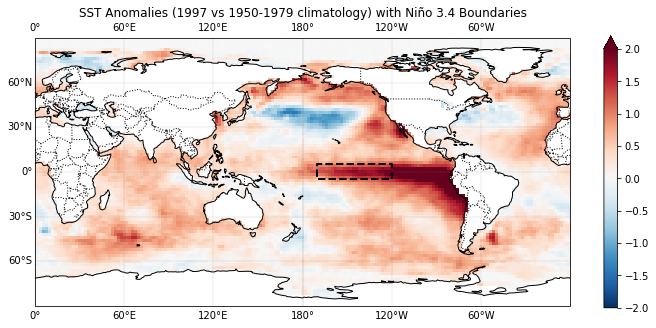

In [15]:
# Set up figure with Cartopy
fig = plt.figure(figsize=(12,5))
proj = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=proj)

# Add map features
ax.coastlines(resolution="110m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_global()
ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5)

# Plot SST anomalies
pcm = sst_anom_1997.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-2, vmax=2,
    add_colorbar=True,
    add_labels=False
)

# Define Nino 3.4 box boundaries
lon_min, lon_max = 190, 240   # 170°W–120°W in 0–360° convention
lat_min, lat_max = -5, 5

# Create a rectangular polygon
n34_box = box(lon_min, lat_min, lon_max, lat_max)

# Add it to the map
ax.add_geometries(
    [n34_box],
    crs=ccrs.PlateCarree(),
    facecolor="none",
    edgecolor="black",
    linewidth=2,
    linestyle="--"
)

# Add title
plt.title("SST Anomalies (1997 vs 1950-1979 climatology) with Niño 3.4 Boundaries", fontsize=12)
plt.show()

In [16]:
# sst_1997_monthly = sst.sel(time="1997")
sst_anom_n34 = sst.sel(lat=slice(-5, 5), lon=slice(190, 240)) - sst_clim

# Take the mean over both lat and lon for each time step
nino34 = sst_anom_n34.mean(dim=["lat", "lon"])

# Apply 5-month centered rolling mean
nino34_smooth = nino34.rolling(time=5, center=True).mean()

# Compute mean and std from baseline (1950–1979)
base_period = slice("1950", "1979")
mean_base = nino34_smooth.sel(time=base_period).mean()
std_base  = nino34_smooth.sel(time=base_period).std()

# Standardize
nino34_std = (nino34_smooth - mean_base) / std_base

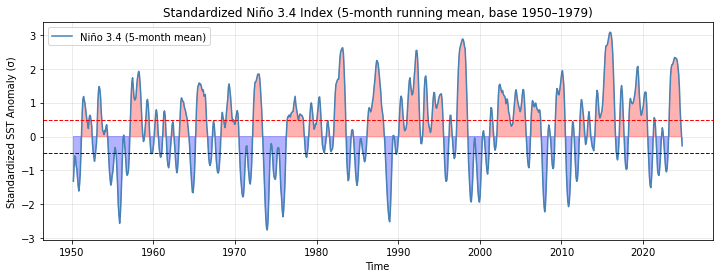

In [17]:
plt.figure(figsize=(12,4))
nino34_std.plot(color="steelblue", lw=1.5, label="Niño 3.4 (5-month mean)")
plt.axhline(0.5, color="r", ls="--", lw=1)
plt.axhline(-0.5, color="b", ls="--", lw=1)
plt.fill_between(nino34_std["time"], 0, nino34_std,
                 where=nino34_std > 0, color="red", alpha=0.3)
plt.fill_between(nino34_std["time"], 0, nino34_std,
                 where=nino34_std < 0, color="blue", alpha=0.3)
plt.title("Standardized Niño 3.4 Index (5-month running mean, base 1950–1979)")
plt.ylabel("Standardized SST Anomaly (σ)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Step 5b. Which Wind Mode Resembles the ENSO Signal?

The Niño 3.4 index represents the standardized SST anomaly in the central–eastern equatorial Pacific. ENSO events affect wind patterns across the tropics, often weakening or reversing the trade winds.

In this step, we’ll check which EOF mode of the 10 m wind field shows the strongest similarity
to the Niño 3.4 index — first numerically (correlation), then visually.

In [18]:
components

<xarray.DataArray 'components' (mode: 5, latitude: 241, longitude: 241)> Size: 2MB
array([[[ 2.70603653e-04,  6.28371695e-04,  4.31163521e-04, ...,
          5.53580935e-04,  5.84446181e-04,  5.87660295e-04],
        [ 6.17412973e-04,  4.00891320e-04,  1.82588032e-04, ...,
          8.47870261e-04,  8.63330932e-04,  8.77393558e-04],
        [ 5.71755337e-04,  3.07741070e-04,  3.00800184e-07, ...,
          1.12564226e-03,  1.13557681e-03,  1.15148702e-03],
        ...,
        [-5.12851535e-04, -4.91599081e-04, -5.27222454e-04, ...,
          3.62074386e-03,  3.33490028e-03,  2.90767828e-03],
        [-4.82263927e-04, -4.53257757e-04, -4.87101107e-04, ...,
          3.96924757e-03,  3.97028323e-03,  3.99867132e-03],
        [-5.07007874e-04, -4.89905856e-04, -5.11944694e-04, ...,
          4.04310447e-03,  4.15891590e-03,  4.27524134e-03]],

       [[-2.58936020e-04, -3.47761793e-04, -3.31739962e-04, ...,
         -5.25439345e-03, -5.25619825e-03, -5.25013177e-03],
        [-2.33670900e-04, -2.54307914e-04, -2.25719206e-04, ...,
         -5.36524806e-03, -5.36190510e-03, -5.35119492e-03],
        [-1.82380198e-04, -1.97400000e-04, -3.13332934e-04, ...,
         -5.47336946e-03, -5.46754891e-03, -5.45364863e-03],
...
        [ 6.69299107e-04,  6.50731233e-04,  6.91597739e-04, ...,
         -1.99243426e-03, -1.81985648e-03, -1.56634114e-03],
        [ 6.51065046e-04,  6.45688932e-04,  6.81157189e-04, ...,
         -2.36893323e-03, -2.36164444e-03, -2.37693086e-03],
        [ 6.79423062e-04,  6.86113624e-04,  7.10553962e-04, ...,
         -2.41167757e-03, -2.49942527e-03, -2.58755665e-03]],

       [[-7.97196716e-04, -2.22558967e-03, -2.17528370e-03, ...,
          1.54973046e-02,  1.55185822e-02,  1.55425640e-02],
        [-1.68025355e-03, -1.36822809e-03, -1.22451328e-03, ...,
          1.55378550e-02,  1.55487002e-02,  1.55631127e-02],
        [-1.63454083e-03, -1.18012431e-03, -9.00057672e-04, ...,
          1.55327356e-02,  1.55377452e-02,  1.55512072e-02],
        ...,
        [ 5.26639713e-04,  5.14127638e-04,  4.99144344e-04, ...,
          1.36854304e-03,  1.26001563e-03,  1.07089639e-03],
        [ 5.22529107e-04,  5.20371091e-04,  4.97870768e-04, ...,
          1.43911461e-03,  1.49303132e-03,  1.55918641e-03],
        [ 4.95657622e-04,  4.94719244e-04,  4.70172755e-04, ...,
          1.33561596e-03,  1.44145341e-03,  1.54726694e-03]]])
Coordinates:
  * latitude   (latitude) float64 2kB 0.0 0.25 0.5 0.75 ... 59.5 59.75 60.0
  * longitude  (longitude) float64 2kB 100.0 100.2 100.5 ... 159.5 159.8 160.0
    number     int64 8B 0
  * mode       (mode) int32 20B 1 2 3 4 5
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-12-06 18:34:50
    n_modes:        5
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

,Correlation
Mode,
5,0.654778
2,0.153794
1,0.140360
3,0.104381
4,-0.187514


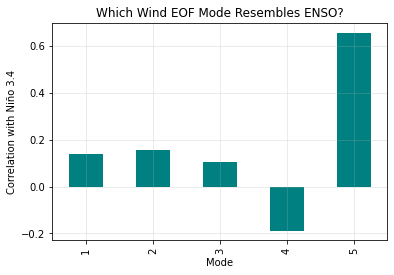

In [19]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# --- Make sure nino34_std is already computed from Step 5A ---
# We'll align it with the wind data period (up to 2024)
nino34_std['time'] = pd.to_datetime(nino34_std['time'].values).to_period('M').to_timestamp()
nino34_std = nino34_std.sel(time=slice("1970", "2024"))

# --- Step 1: Compute correlation for each EOF mode ---
corrs = []

for mode_num in model.components()["mode"].values:
    pc = model.scores().sel(mode=mode_num)

    # Smooth and standardize (same as Niño 3.4)
    pc_smooth = pc.rolling(time=5, center=True).mean()
    pc_std = (pc_smooth - pc_smooth.mean(dim='time')) / pc_smooth.std(dim='time')

    # Align in time
    pc_std['time'] = pd.to_datetime(pc_std['time'].values).to_period('M').to_timestamp()
    pc_std = pc_std.sel(time=slice("1970", "2024"))
    pc_std, nino_aligned = xr.align(pc_std, nino34_std, join='inner')

    # Compute correlation
    r = float(xr.corr(pc_std, nino_aligned, dim='time').values)
    corrs.append((mode_num, r))

# --- Step 2: Display results ---
import pandas as pd
corr_df = pd.DataFrame(corrs, columns=['Mode', 'Correlation']).set_index('Mode')
display(corr_df.sort_values('Correlation', ascending=False))

# --- Step 3: Plot correlation as bar chart ---
corr_df.plot.bar(color='teal', legend=False)
plt.ylabel('Correlation with Niño 3.4')
plt.title('Which Wind EOF Mode Resembles ENSO?')
plt.grid(alpha=0.3)
plt.show()


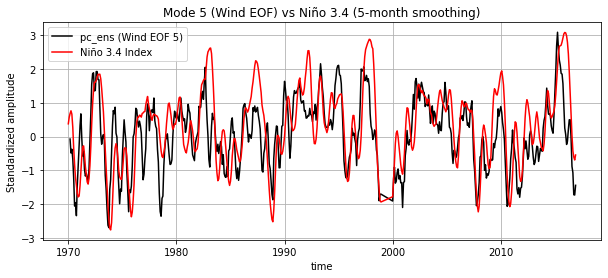

Correlation (pc_ens vs Niño 3.4): 0.66


In [20]:
# --- Choose the mode that looks most similar to the ENSO pattern ---
ens_mode = 5

pc_ens = model.scores().sel(mode=ens_mode)

# Apply 5-month centered rolling mean
pc_ens_smooth = pc_ens.rolling(time=5, center=True).mean()

# Standardize (zero mean, unit variance)
pc_ens_std = (pc_ens_smooth - pc_ens_smooth.mean(dim='time')) / pc_ens_smooth.std(dim='time')

# import pandas as pd

pc_ens_std['time'] = pd.to_datetime(pc_ens_std['time'].values).to_period('M').to_timestamp()
nino34_std['time'] = pd.to_datetime(nino34_std['time'].values).to_period('M').to_timestamp()

pc_ens_std = pc_ens_std.sel(time=slice("1970", "2016"))
nino34_std = nino34_std.sel(time=slice("1970", "2016"))


# import matplotlib.pyplot as plt
# import xarray as xr

# Align and plot
pc_ens_std, nino34_std_aligned = xr.align(pc_ens_std, nino34_std, join='inner')

plt.figure(figsize=(10,4))
pc_ens_std.plot(label='pc_ens (Wind EOF 5)', color='k')
nino34_std_aligned.plot(label='Niño 3.4 Index', color='r')
plt.legend(); plt.grid(True)
plt.ylabel('Standardized amplitude')
plt.title('Mode 5 (Wind EOF) vs Niño 3.4 (5-month smoothing)')
plt.show()

# Compute correlation
r = xr.corr(pc_ens_std, nino34_std_aligned, dim='time')
print(f'Correlation (pc_ens vs Niño 3.4): {float(r.values):.2f}')


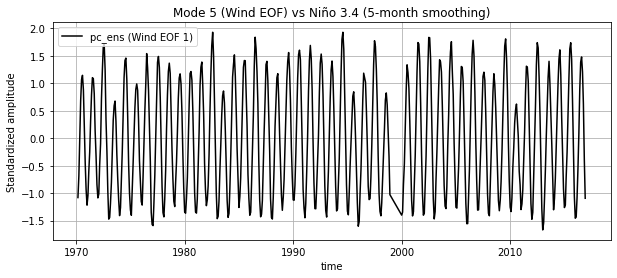

In [22]:
# --- Choose the mode that looks most similar to the ENSO pattern ---
ens_mode = 1

pc_ens = model.scores().sel(mode=ens_mode)

# Apply 5-month centered rolling mean
pc_ens_smooth = pc_ens.rolling(time=5, center=True).mean()

# Standardize (zero mean, unit variance)
pc_ens_std = (pc_ens_smooth - pc_ens_smooth.mean(dim='time')) / pc_ens_smooth.std(dim='time')

# import pandas as pd

pc_ens_std['time'] = pd.to_datetime(pc_ens_std['time'].values).to_period('M').to_timestamp()
nino34_std['time'] = pd.to_datetime(nino34_std['time'].values).to_period('M').to_timestamp()

pc_ens_std = pc_ens_std.sel(time=slice("1970", "2016"))
nino34_std = nino34_std.sel(time=slice("1970", "2016"))


# import matplotlib.pyplot as plt
# import xarray as xr

# Align and plot
pc_ens_std, nino34_std_aligned = xr.align(pc_ens_std, nino34_std, join='inner')

plt.figure(figsize=(10,4))
pc_ens_std.plot(label='pc_ens (Wind EOF 1)', color='k')
#nino34_std_aligned.plot(label='Niño 3.4 Index', color='r')
plt.legend(); plt.grid(True)
plt.ylabel('Standardized amplitude')
plt.title('Mode 5 (Wind EOF) vs Niño 3.4 (5-month smoothing)')
plt.show()

# Compute correlation
#r = xr.corr(pc_ens_std, nino34_std_aligned, dim='time')
#print(f'Correlation (pc_ens vs Niño 3.4): {float(r.values):.2f}')

#### Questions

1. How closely do the peaks and troughs of the two series align across time?<br>
**The peaks and troughs are similar enough, but do sometimes show a lag time of maybe 5-10 months.**
2. What does the sign of the correlation (positive or negative) tell you about the wind response to El Niño and La Niña?<br>
**The positive correlation shows us that the wind response is positively related to El Niño and La Niña. A negative correlation would mean that the behavior of the strengthening of the winds relate to the weakening of ENSO.**
3. Do the strongest El Niño years (e.g., 1982–83, 1997–98, 2015–16) appear clearly in your chosen mode’s PC?<br>
**The strongest El Niño years are indeed shown in Mode 4 of the wind EOF.**
4. Does the relationship remain stable across decades, or does it vary?<br>
**The relationship varies across decades, with some peaks accurately being correlated, while some not so much.**
5. What could explain any lag or mismatch between the wind and SST anomalies?<br>
**The mismatch could be brought by the relationship of SST and wind to begin with, where wind directions might influence the speed of the movement of the SSTs across the surface of the Pacific.**

---

In this exercise, you explored how EOF analysis helps separate different scales of wind variability — the seasonal monsoon cycle and the interannual ENSO influence.
Review your results and reflect on what they reveal about tropical climate dynamics.

### Final Questions
1. How does EOF 1 capture the large-scale monsoon reversal between Amihan and Habagat?<br>
**EOF 1 captures the most dominating spatial patterns over a specific period of time. Since Amihan and Habagat are large-scale systems that occur seasonally, it is reflected in EOF 1, where each decade has approximately 10 cycles of the standardized amplitudes, indicating the yearly shifting of the winds from amihan to habagat.**
2. What distinguishes your chosen ENSO-related mode (spatially and temporally) from EOF 1?<br>
**The ENSO related mode (EOF 5) has patterns that do not necessarily appear strongly, but features are still detectable. Spatially, EOF 1 has features that are very obvious, like when westerlies are the strongest. EOF 1 also has a a yearly pattern. In comparison, ENSO has a smaller area (focused on the tropical Pacific), with temporal variation that range from 1-3 years.**
3. How do the Niño 3.4 index and your wind mode’s PC move together during major El Niño and La Niña events?<br>
**The Niño 3.4 index and the chosen wind mode show trends that move upwards and downwards together, although not perfectly. This means that the ENSO events are very closely linked, and most likely cause, changes in wind patterns over the period.**
4.  What might explain periods when their relationship weakens or shifts over time?<br>
**Since the Niño 3.4 index is essentially a record of SSTs over an area in the Pacific, the recordings in this area could tell us about the behavior of wind in that area. This means, any strengthening or weakening of the signal of the index will correspond to an appropriate change in the wind pattern displayed.**
5. In what ways do seasonal and interannual variability interact to influence Philippine or western Pacific climate patterns?<br>
**The combination of seasonal and interannual has profound effects on Philippine climate. The seasonal winds are responsible for majority fo the climate variability in the country, manifesting in the different climate zones. The ENSO, or the strongest interannual signal in the Pacific, further influences and enhances the pre-existing wet and dry seasons, by governing the flow of moisture in the atmosphere.**
6. How could similar EOF methods be extended to study other variables (e.g., pressure, rainfall, SST)?<br>
**EOF methods can be used to study spatial patterns that are exhibited in a dataset. This means that not only can we have patterns we can observe that are easier to interpret because of their visualization on an actual physical space, this is also could give information about the climate in an area. Pressure, rainfall, and SST trends are all things that could be related in climatology, and even the formation of more localized events, like tropical cyclones.**